# Visualization of nucleotide embeddings produced by SpliceBERT

In [1]:
import os
import sys
import json
import scanpy as sc
import pickle
import gzip
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
sys.path.append("../scripts")
from utils import set_spines, get_figure_size
from sklearn.metrics import homogeneity_score, adjusted_rand_score

In [2]:
np.random.seed(2023)

In [3]:
## run script to generate data for visualization
#! export CUDA_VISIBLE_DEVICES=0 && ./pipeline.sh

## compare different methods  
(The last layer hidden states are used in this section)  

In [4]:
splicebert_ss = sc.read_h5ad("./output/hg19.ss-motif.for_umap.SpliceBERT.L4.h5ad")
splicebert_human_ss = sc.read_h5ad("./output/hg19.ss-motif.for_umap.SpliceBERT-human.L6.h5ad")
dnabert_ss = dict()
for k in [3, 4, 5, 6]:
    dnabert_ss[k] = sc.read_h5ad(f"./output/hg19.ss-motif.for_umap.DNABERT{k}.L12.h5ad")
onehot_ss = dict()
for k in [10, 20, 50, 100, 200]:
    onehot_ss[k] = sc.read_h5ad(f"./output/hg19.ss-motif.for_umap.onehot.flanking{k}.h5ad")

splicebert_sse = sc.read_h5ad("./output/K562.SSE.hg38.for_visualization.SpliceBERT.L6.h5ad")
splicebert_human_sse = sc.read_h5ad("./output/K562.SSE.hg38.for_visualization.SpliceBERT-human.L6.h5ad")
dnabert_sse = dict()
for k in [3, 4, 5, 6]:
    dnabert_sse[k] = sc.read_h5ad(f"./output/K562.SSE.hg38.for_visualization.DNABERT{k}.L12.h5ad")
onehot_sse = dict()
for k in [10, 20, 50, 100, 200]:
    onehot_sse[k] = sc.read_h5ad(f"./output/K562.SSE.hg38.for_visualization.onehot.flanking{k}.h5ad")

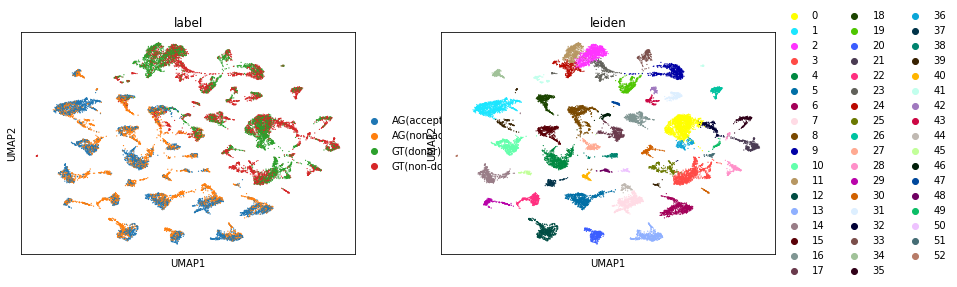

In [5]:
sc.pl.umap(dnabert_ss[3], color=["label", "leiden"])

In [21]:
splicebert_sse.obs["label"].unique()

['acceptor(SSE < 0.2)', 'donor(SSE < 0.2)', 'acceptor(SSE > 0.8)', 'donor(SSE > 0.8)']
Categories (4, object): ['acceptor(SSE < 0.2)', 'acceptor(SSE > 0.8)', 'donor(SSE < 0.2)', 'donor(SSE > 0.8)']

In [31]:
def cal_metric_by_group(labels, preds, metric_fun, by_group: bool=True):
    if by_group:
        k1 = np.isin(labels, ['GT(donor)', "GT(non-donor)", 'donor(SSE < 0.2)', 'donor(SSE > 0.8)'])
        score1 = metric_fun(labels[k1], preds[k1])
        k2 = np.isin(labels, ['AG(acceptor)', "AG(non-acceptor)", 'acceptor(SSE < 0.2)', 'acceptor(SSE > 0.8)'])
        score2 = metric_fun(labels[k2], preds[k2])
        return (score1 + score2) / 2
    else:
        return metric_fun(labels, preds)

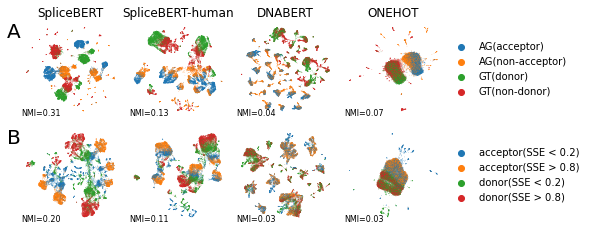

In [32]:
from sklearn.metrics import homogeneity_score, v_measure_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
## compare SpliceBERT with SpliceBERT-human
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=get_figure_size(1, 0.4))

metric_fun = normalized_mutual_info_score
args = dict(show=False, legend_loc=None, s=1)
loc = (-0.01, 1)
mark_loc = (0.2, 0.07)
mark_size = 8

ax = axs[0, 0]
# add figure index (A/B/C)
ax.text(*loc, "A", transform=ax.transAxes, fontsize=20, fontweight='normal', va='top', ha='right')
sc.pl.umap(splicebert_ss, color=["label"], ax=ax, title="SpliceBERT", **args)
# mark nmi_score
# nmi_score = metric_fun(splicebert_ss.obs["label"], splicebert_human_ss.obs["leiden"])
nmi_score = cal_metric_by_group(splicebert_ss.obs["label"], splicebert_ss.obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')
ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

ax = axs[0, 1]
sc.pl.umap(splicebert_human_ss, color=["label"], ax=ax, title="SpliceBERT-human", **args)
# nmi_score = metric_fun(splicebert_human_ss.obs["label"], splicebert_human_ss.obs["leiden"])
nmi_score = cal_metric_by_group(splicebert_human_ss.obs["label"], splicebert_human_ss.obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')
ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

ax = axs[0, 2]
sc.pl.umap(dnabert_ss[3], color=["label"], ax=ax, title="DNABERT", **args)
# nmi_score = metric_fun(dnabert_ss[3].obs["label"], dnabert_ss[3].obs["leiden"])
nmi_score = cal_metric_by_group(dnabert_ss[3].obs["label"], dnabert_ss[3].obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')

ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

ax = axs[0, 3]
args["legend_loc"] = "right margin"
sc.pl.umap(onehot_ss[100], color=["label"], ax=ax, title="ONEHOT", **args)
# nmi_score = metric_fun(onehot_ss[100].obs["label"], onehot_ss[100].obs["leiden"])
nmi_score = cal_metric_by_group(onehot_ss[100].obs["label"], onehot_ss[100].obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')

ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

args = dict(show=False, legend_loc=None, s=1, title="")
ax = axs[1, 0]
ax.text(*loc, "B", transform=ax.transAxes, fontsize=20, fontweight='normal', va='top', ha='right')
sc.pl.umap(splicebert_sse, color=["label"], ax=ax, **args)
# nmi_score = metric_fun(splicebert_sse.obs["label"], splicebert_sse.obs["leiden"])
nmi_score = cal_metric_by_group(splicebert_sse.obs["label"], splicebert_sse.obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')

ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

ax = axs[1, 1]
sc.pl.umap(splicebert_human_sse, color=["label"], ax=ax, **args)
# nmi_score = metric_fun(splicebert_human_sse.obs["label"], splicebert_human_sse.obs["leiden"])
nmi_score = cal_metric_by_group(splicebert_human_sse.obs["label"], splicebert_human_sse.obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')

ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

ax = axs[1, 2]
sc.pl.umap(dnabert_sse[3], color=["label"], ax=ax, **args)
# nmi_score = metric_fun(dnabert_sse[3].obs["label"], dnabert_sse[3].obs["leiden"])
nmi_score = cal_metric_by_group(dnabert_sse[3].obs["label"], dnabert_sse[3].obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')

ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")

ax = axs[1, 3]
args["legend_loc"] = "right margin"
sc.pl.umap(onehot_sse[100], color=["label"], ax=ax, **args)
# nmi_score = metric_fun(onehot_sse[100].obs["label"], onehot_sse[100].obs["leiden"])
nmi_score = cal_metric_by_group(onehot_sse[100].obs["label"], onehot_sse[100].obs["leiden"], metric_fun)
ax.text(*mark_loc, f"NMI={nmi_score:.2f}", transform=ax.transAxes, fontsize=mark_size, fontweight='normal', va='top', ha='center')

ax.set_xlabel("")
ax.set_ylabel("")
set_spines(ax=ax, bottom=False, left=False)
# ax.set_aspect("equal")



plt.tight_layout()
plt.savefig("Figure_3.jpg", dpi=600, bbox_inches="tight")
plt.show()

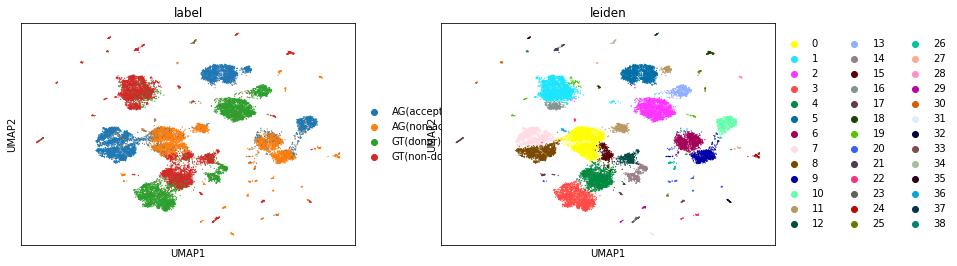

In [33]:
sc.pl.umap(splicebert_ss, color=["label", "leiden"])

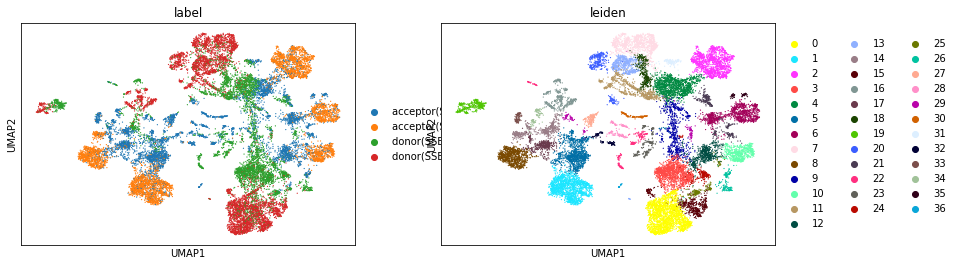

In [34]:
sc.pl.umap(splicebert_sse, color=["label", "leiden"])

## Supplementary figures

In [35]:
# compare SpliceBERT embedding per layer
splicebert_gt = dict()
splicebert_ag = dict()
for l in range(1, 7):
    splicebert_gt[l] = sc.read_h5ad(f"./output/hg19.ss-motif.for_umap.SpliceBERT.L{l}.GT.h5ad")
    splicebert_ag[l] = sc.read_h5ad(f"./output/hg19.ss-motif.for_umap.SpliceBERT.L{l}.AG.h5ad")

In [38]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

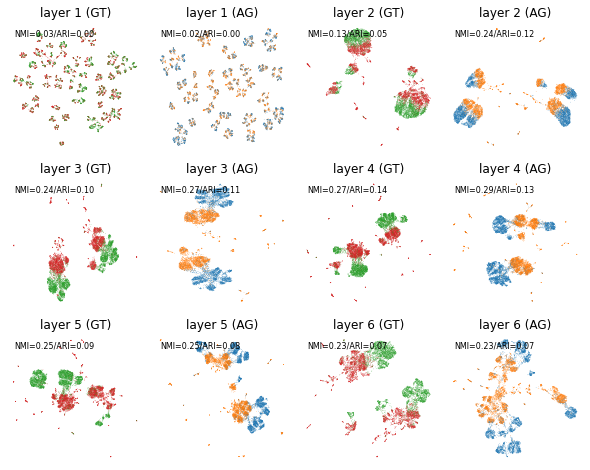

In [39]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=get_figure_size(1, 0.8))
for i, l in enumerate([1, 2, 3, 4, 5, 6]):
    ax = axs[(i * 2) // 4, (i * 2) % 4]
    sc.pl.umap(splicebert_gt[l], color=["label"], ax=ax, title=f"layer {l} (GT)", show=False, legend_loc=None, s=1, palette={"GT(donor)": "tab:green", "GT(non-donor)": "tab:red"})
    ax.set_xlabel("")
    ax.set_ylabel("")
    set_spines(ax=ax, bottom=False, left=False)
    nmi = normalized_mutual_info_score(splicebert_gt[l].obs["label"], splicebert_gt[l].obs["leiden"])
    ari = adjusted_rand_score(splicebert_gt[l].obs["label"], splicebert_gt[l].obs["leiden"])
    ax.text(0.05, 0.95, f"NMI={nmi:.2f}/ARI={ari:.2f}", transform=ax.transAxes, va="top", ha="left", fontsize=8)

    ax = axs[(i * 2) // 4, (i * 2) % 4 + 1]
    sc.pl.umap(splicebert_ag[l], color=["label"], ax=ax, title=f"layer {l} (AG)", show=False, legend_loc=None, s=1)
    ax.set_xlabel("")
    ax.set_ylabel("")
    set_spines(ax=ax, bottom=False, left=False)
    nmi = normalized_mutual_info_score(splicebert_ag[l].obs["label"], splicebert_ag[l].obs["leiden"])
    ari = adjusted_rand_score(splicebert_ag[l].obs["label"], splicebert_ag[l].obs["leiden"])
    ax.text(0.05, 0.95, f"NMI={nmi:.2f}/ARI={ari:.2f}", transform=ax.transAxes, va="top", ha="left", fontsize=8)

plt.tight_layout()
plt.savefig("Figure_S_SpliceBERT-layer.jpg", dpi=600, bbox_inches="tight")
plt.show()

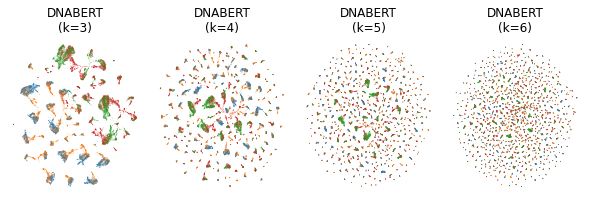

In [9]:
# compare DNABERT with different token length
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=get_figure_size(1, 0.35))
size = 1
for k in range(3, 7):
    ax = axs[k-3]
    sc.pl.umap(dnabert_ss[k], color=["label"], ax=ax, title=f"DNABERT\n(k={k})", show=False, legend_loc=None, s=size)
    set_spines(ax=ax, bottom=False, left=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.savefig("Figure_S_dnabert.jpg", dpi=600, bbox_inches="tight")
plt.show()

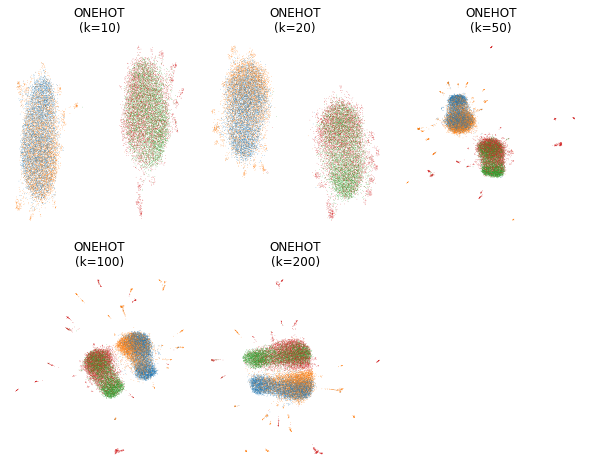

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=get_figure_size(1, 0.8))
for i, k in enumerate([10, 20, 50, 100, 200, None]):
    ax = axs[i//3, i%3]
    if k is not None:
        sc.pl.umap(onehot_ss[k], color=["label"], ax=ax, title=f"ONEHOT\n(k={k})", show=False, legend_loc=None, s=size)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

    set_spines(ax=ax, bottom=False, left=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()
plt.savefig("Figure_S_onehot.jpg", dpi=600, bbox_inches="tight")
plt.show()